In [2]:
import numpy as np
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from cosmoTransitions import generic_potential_Gegenbauer
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc
from scipy.special import gegenbauer
from scipy.special import eval_gegenbauer
from scipy.special import roots_gegenbauer
import math 




%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size

label_size=20
thick_size=20



####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpolation function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
gtab = np.loadtxt( 'standardmodel2018.txt' )[::20]
g_star=interpolate.interp1d(gtab[::,0], gtab[::,1], kind='cubic')
g_sstar=interpolate.interp1d(gtab[::,0], gtab[::,3], kind='cubic')


def Hubble_radiation(T):
    """Hubble rate (squared) coming from radiation dof"""
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared




####MY FUNCTIONS START HERE      

def GBpotential(Ngb,n,z):
    lam=(Ngb-1)/2
    x=np.cos(z)
    return eval_gegenbauer(n,lam,x)

def GBpotential_roots(Ngb,n):
    """Return the roots of the Gegenbauer polynomial"""
    lam=(Ngb-1)/2
    output=roots_gegenbauer(n,lam)[0]
    return sorted(np.arccos(output[output>0]))
                 

def findGBminima(Ngb,n,roots_list):
    "Find the all minima of the Gegenbauer polynomial between 0 and pi/2"
    fun=lambda z:GBpotential(Ngb,n,z)
    output=[]
    for i in range(len(roots_list)):
        if 2*i+1==len(roots_list) or 2*i==len(roots_list):
            break
        solmin=optimize.minimize_scalar(fun,bounds=(roots_list[2*i],roots_list[2*i+1]),method="bounded",options={"disp":False})
        output.append(solmin.x)
    return np.array(output)


def Gamma_S4(vev,action):
    """ This function returns the decay rate for 
    a 4D zero temperature transition"""
    return vev**4*(action/2/np.pi)**2*np.exp(-action)



In [3]:
class model1(generic_potential_Gegenbauer.generic_potential):

    def init(self, Ngb=4, n=20,Mscale=1000,f=1000,epsilon=1e-3):
        self.Ndim = 1
        self.Ngb=Ngb
        self.n=n
        self.f=f
        self.epsilon=epsilon
        self.Mscale=Mscale
        self.const=self.f**2*self.epsilon*self.Mscale**2
        self.findVacua_list()
        self.renormScaleSq = (self.f)**2

    
    def findVacua_list(self):
        """This function finds ALL the minima of the T=0 potential, including the CW piece.
        Stores the list in self.vacua_list"""
        roots=GBpotential_roots(self.Ngb,self.n)
        root_list=findGBminima(self.Ngb,self.n,roots) 
        #min_list=[]
        #for h0 in np.array(root_list)*self.f:
        #    min_list.append(float(self.findMinimum(h0,0)))
        self.vacua_list=np.array(root_list)
        return
    def findVacua_list_old(self):
        """This function finds ALL the minima of the T=0 potential, including the CW piece.
        Stores the list in self.vacua_list"""
        roots=GBpotential_roots(self.Ngb,self.n)
        root_list=findGBminima(self.Ngb,self.n,roots) 
        min_list=[]
        for h0 in np.array(root_list)*self.f:
            min_list.append(float(self.findMinimum(h0,0)))
        self.vacua_list=np.array(min_list)/self.f
        return
 
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h = X[...]
        z=h/self.f
        pot =self.const*GBpotential(self.Ngb,self.n,z)
        
        return pot
    
    def boson_massSq(self, X, T):
        X = np.asanyarray(X)
        h = X[...,]
        
        ##Determine normalization constant
        #fun=lambda x :self.V0(x)
        #DG=misc.derivative(fun, x0=h,  n=1)
        #D2G=misc.derivative(fun, x0=h, n=2)
        #Mh2=D2G
        #MG2=DG/np.tan(h/self.f)/self.f
        lam=(self.Ngb-1)/2.
        x=h/self.f
        
        Mh2=-np.cos(x)*eval_gegenbauer(self.n-1,lam+1,np.cos(x))
        Mh2+=2*(1+lam)*eval_gegenbauer(self.n-2,lam+2,np.cos(x))*np.sin(x)**2
        Mh2*=2*self.Mscale**2*self.epsilon*lam
        
        MG2=-2*self.Mscale**2*self.epsilon*lam*np.cos(x)*eval_gegenbauer(self.n-1,lam+1,np.cos(x))
        
        M = np.array([Mh2,MG2])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1,self.Ngb-1])

        c = np.array([.5,.5])

        return M, dof, c

    
    def plot1(self):
        z_range=np.linspace(0,self.f*np.pi/2,200)

        plt.plot(z_range,self.V0(z_range),label="Tree-level")
        if len(self.vacua_list)==0:
            self.findVacua_list()
        plt.scatter(self.vacua_list*self.f,self.V0(self.f*self.vacua_list))

        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.legend()
        plt.legend(prop={'size': label_size})
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        #mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
        #plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    
    def approxZeroTMin(self):
        if self.vacua_list==[]:
            self.findVacua_list()
        return list(self.vacua_list*self.f)
    
def epsilon_bound(f,Mscale,n,Ngb):
    epsilon_max=24*f**2/Mscale**2*16*np.pi**2*Ngb/3
    epsilon_max*=math.factorial(Ngb)*math.factorial(n-1)
    epsilon_max*=1/(math.factorial(n+Ngb-1)*n*(Ngb-1)*(Ngb + n - 1))
    return epsilon_max
    


    

        
  

# How is the variation of $\epsilon$ with n and N

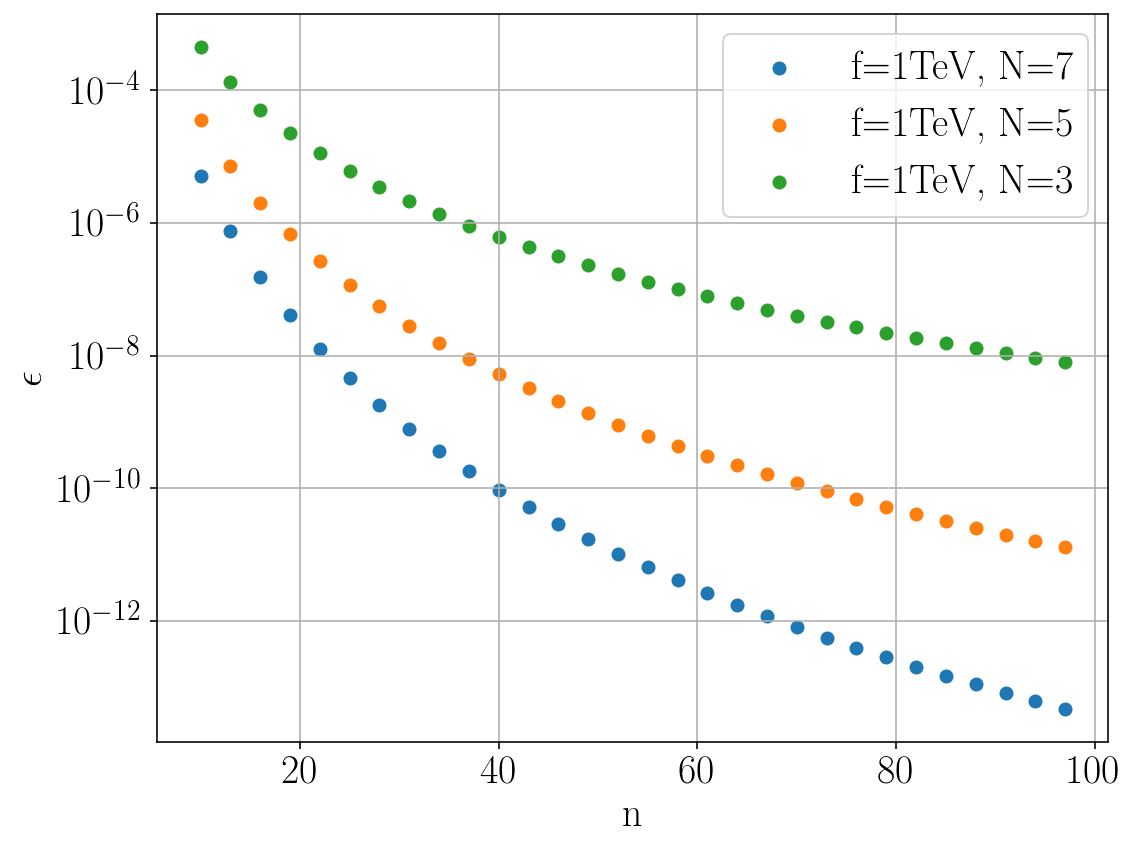

In [3]:
plt.scatter(range(10,100,3),[epsilon_bound(1000,4*np.pi*1000,n,7) for n in range(10,100,3)],label="f=1TeV, N=7")
plt.scatter(range(10,100,3),[epsilon_bound(1000,4*np.pi*1000,n,5) for n in range(10,100,3)],label="f=1TeV, N=5")
plt.scatter(range(10,100,3),[epsilon_bound(1000,4*np.pi*1000,n,3) for n in range(10,100,3)],label="f=1TeV, N=3")
plt.yscale("log")
plt.xlabel("n",size=label_size)
plt.ylabel("$\epsilon$",size=label_size)

plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.tight_layout()


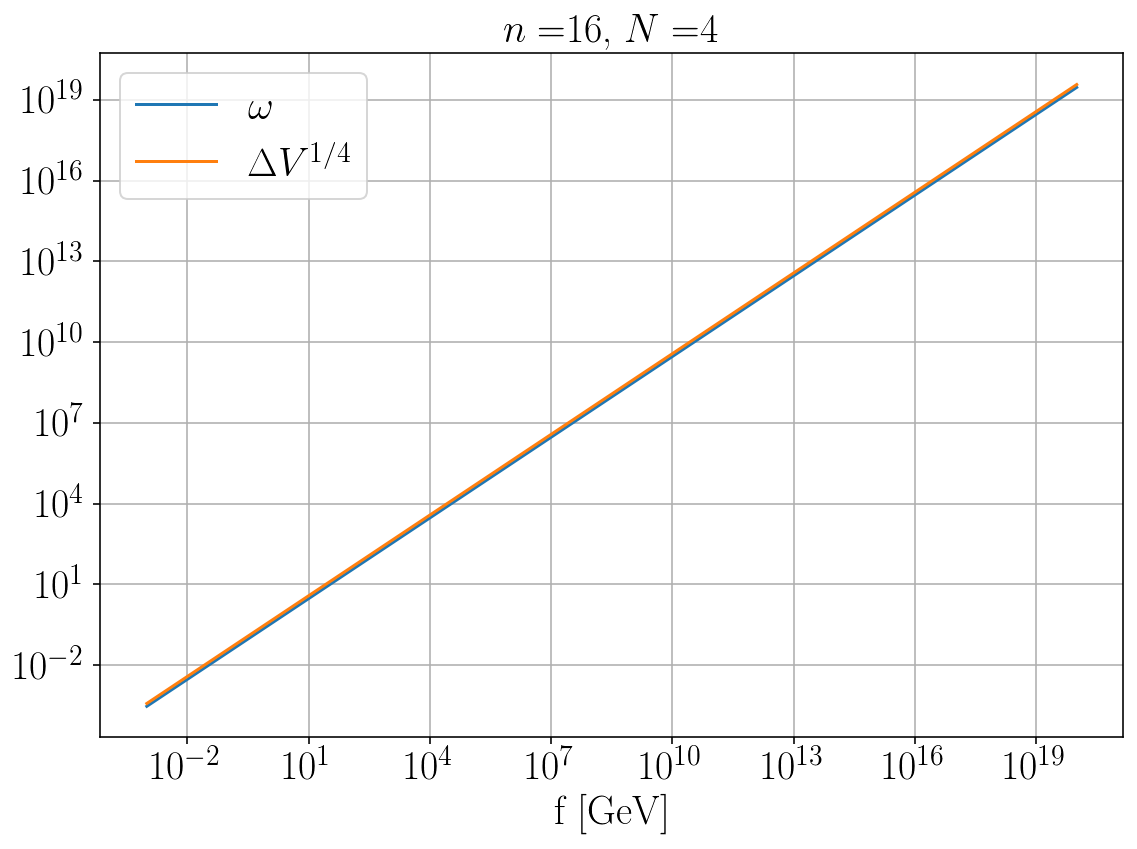

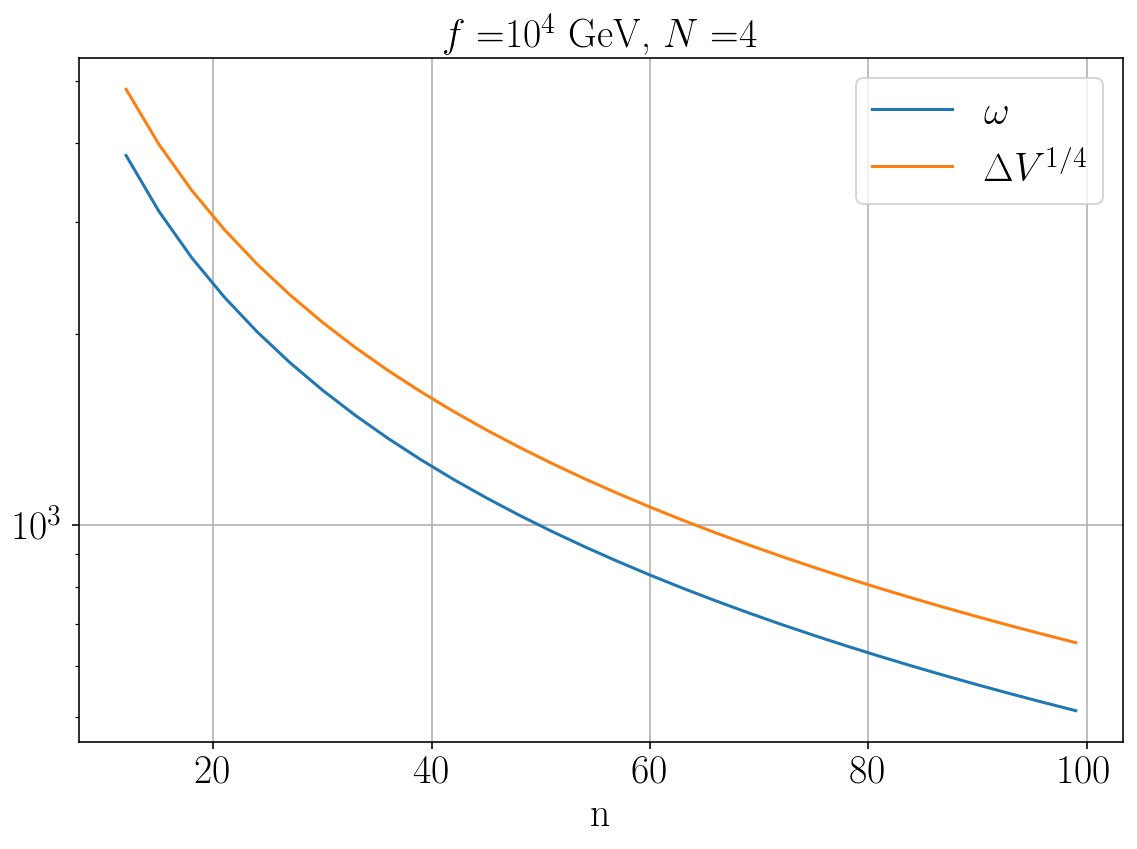

In [4]:
def find_DV(Ngb_val, n_val, Mscale_val, f_val, epsilon):
    """This function is used to to find the potential energy difference and  
    the global minimum """
    m=model1(Ngb=Ngb_val, n=n_val,Mscale=Mscale_val,f=f_val,epsilon=epsilon)
    phi_absMin,phi_metaMin = (m.vacua_list*m.f)[0:2]
    return  phi_absMin,np.sqrt(np.sqrt(m.V0(phi_metaMin)-m.V0(phi_absMin)))


Ngb_val=4
n_val=16
vals_list=[]
f_range=np.logspace(-3,20,100)
for f_val in f_range:
    Mscale_val=4*np.pi*f_val
    epsilon_val=epsilon_bound(f_val, Mscale_val,n_val, Ngb_val)
    omega,DV=find_DV(Ngb_val, n_val, Mscale_val, f_val, epsilon_val)
    vals_list.append([omega,DV])
plt.plot(f_range,np.array(vals_list).T[0],label="$\\omega$")
plt.plot(f_range,np.array(vals_list).T[1],label="$\\Delta V^{1/4}$")
plt.yscale("log")
plt.xscale("log")
plt.legend(prop={'size': label_size})
plt.xlabel("f [GeV]",size=label_size)
plt.title("$n=$"+str(n_val)+", $N=$"+str(Ngb_val) ,size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.tight_layout()
plt.show()


Ngb_val=4
#n_val=16
f_val=1e4
Mscale_val=4*np.pi*f_val
vals_list=[]
n_range=np.arange(12,100,3)
for n_val in n_range:
    epsilon_val=epsilon_bound(f_val, Mscale_val,n_val, Ngb_val)
    omega,DV=find_DV(Ngb_val, n_val, Mscale_val, f_val, epsilon_val)
    vals_list.append([omega,DV])
plt.plot(n_range,np.array(vals_list).T[0],label="$\\omega$")
plt.plot(n_range,np.array(vals_list).T[1],label="$\\Delta V^{1/4}$")
plt.yscale("log")
plt.legend(prop={'size': label_size})
plt.xlabel("n",size=label_size)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $N=$"+str(Ngb_val) ,size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.tight_layout()
plt.show()

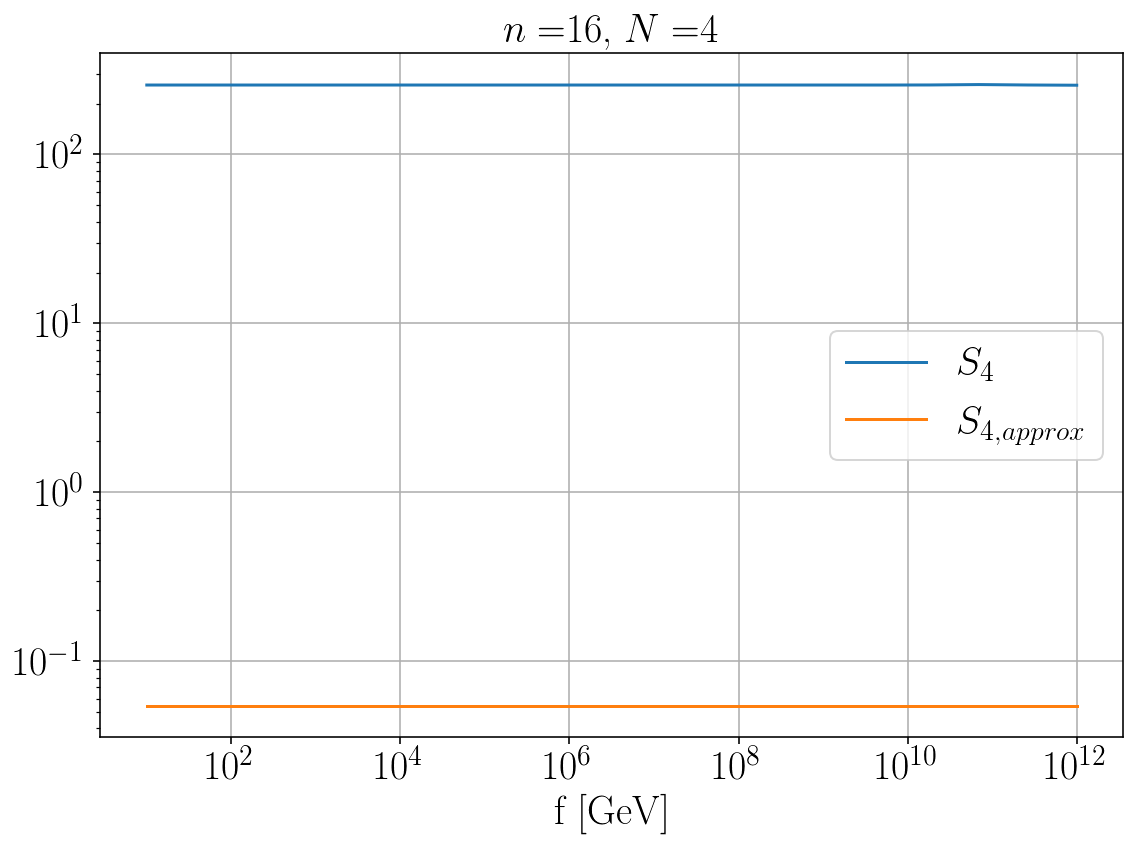

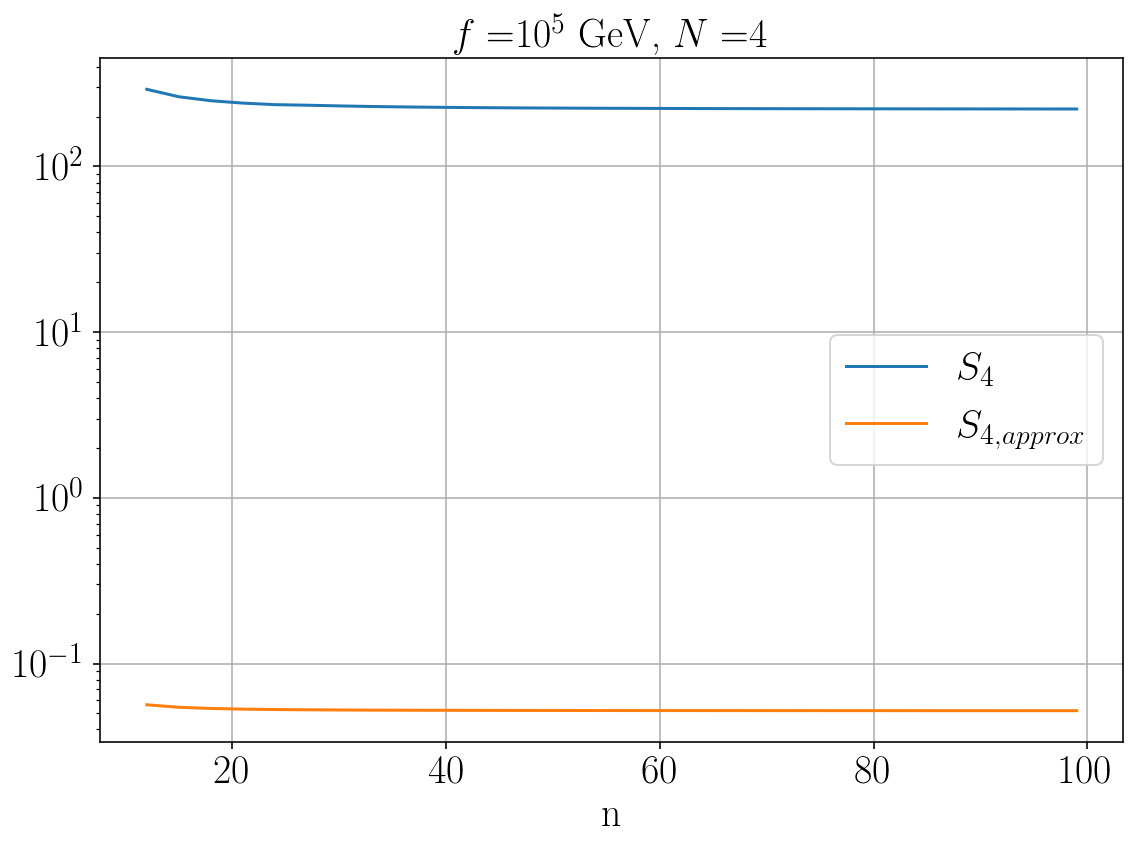

In [5]:
def find_S4(Ngb_val, n_val, Mscale_val, f_val, epsilon):
    """This function is used to find S4"""
    m=model1(Ngb=Ngb_val, n=n_val,Mscale=Mscale_val,f=f_val,epsilon=epsilon)
    phi_absMin,phi_metaMin = (m.vacua_list*m.f)[0:2]
    instanton=SingleFieldInstanton(phi_absMin, phi_metaMin,m.V0,alpha=3 )
    profile=instanton.findProfile()
    S4=instanton.findAction(profile)
    S4_approx=(phi_absMin**4/(m.V0(phi_metaMin)-m.V0(phi_absMin)))**3
    return S4, S4_approx


Ngb_val=4
n_val=16
#f_val=1e13
vals_list=[]
f_range=np.logspace(1,12,20)
for f_val in f_range:
    Mscale_val=4*np.pi*f_val
    epsilon_val=epsilon_bound(f_val, Mscale_val,n_val, Ngb_val)
    S4,S4_approx=find_S4(Ngb_val, n_val, Mscale_val, f_val, epsilon_val)
    vals_list.append([S4,S4_approx])
plt.plot(f_range,np.array(vals_list).T[0],label="$S_4$")
plt.plot(f_range,np.array(vals_list).T[1],label="$S_{4,approx}$")
plt.xscale("log")
plt.yscale("log")
plt.legend(prop={'size': label_size})
plt.xlabel("f [GeV]",size=label_size)
plt.title("$n=$"+str(n_val)+", $N=$"+str(Ngb_val) ,size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.tight_layout()
plt.show()

Ngb_val=4
#n_val=16
f_val=1e5
Mscale_val=4*np.pi*f_val
vals_list=[]
n_range=np.arange(12,100,3)
for n_val in n_range:
    epsilon_val=epsilon_bound(f_val, Mscale_val,n_val, Ngb_val)
    S4,S4_approx=find_S4(Ngb_val, n_val, Mscale_val, f_val, epsilon_val)
    vals_list.append([S4,S4_approx])
plt.plot(n_range,np.array(vals_list).T[0],label="$S_4$")
plt.plot(n_range,np.array(vals_list).T[1],label="$S_{4,approx}$")
plt.yscale("log")
plt.legend(prop={'size': label_size})
plt.xlabel("n",size=label_size)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $N=$"+str(Ngb_val) ,size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.tight_layout()
plt.show()



In [23]:
Ngb_val=4
n_val=20
f_val=1
Mscale_val=f_val
#Mscale_val=4*np.pi*f_val

def find_epsilon(epsilon):
    """This function is used to plot Gamma/Hmin**4 and is used to find the 
    minimum value of epsilon such that nucleation is possible"""
    m=model1(Ngb=Ngb_val, n=n_val,Mscale=Mscale_val,f=f_val,epsilon=epsilon)
    phi_absMin,phi_metaMin = (m.vacua_list*m.f)[0:2]
    instanton=SingleFieldInstanton(phi_absMin, phi_metaMin,m.V0,alpha=3 )
    profile=instanton.findProfile()
    S4=instanton.findAction(profile)
    Hmin2=(m.V0(phi_metaMin)-m.V0(phi_absMin))/3/Mplanck**2
    return Gamma_S4(phi_absMin,S4)/(Hmin2**2)



epsilon_max=epsilon_bound(f_val,Mscale_val,n_val,Ngb_val)
eps_range=np.logspace(np.round(np.log10(epsilon_max))-1,np.round(np.log10(epsilon_max))+3)
nucleation_range=[find_epsilon(x) for x in eps_range]

Nucfun=interpolate.interp1d(eps_range,nucleation_range)
epsilon=optimize.root_scalar(lambda x:1-Nucfun(x),bracket=(epsilon_max,eps_range[-1]),method="ridder").root

epsilon/epsilon_max

1.3127796131595513

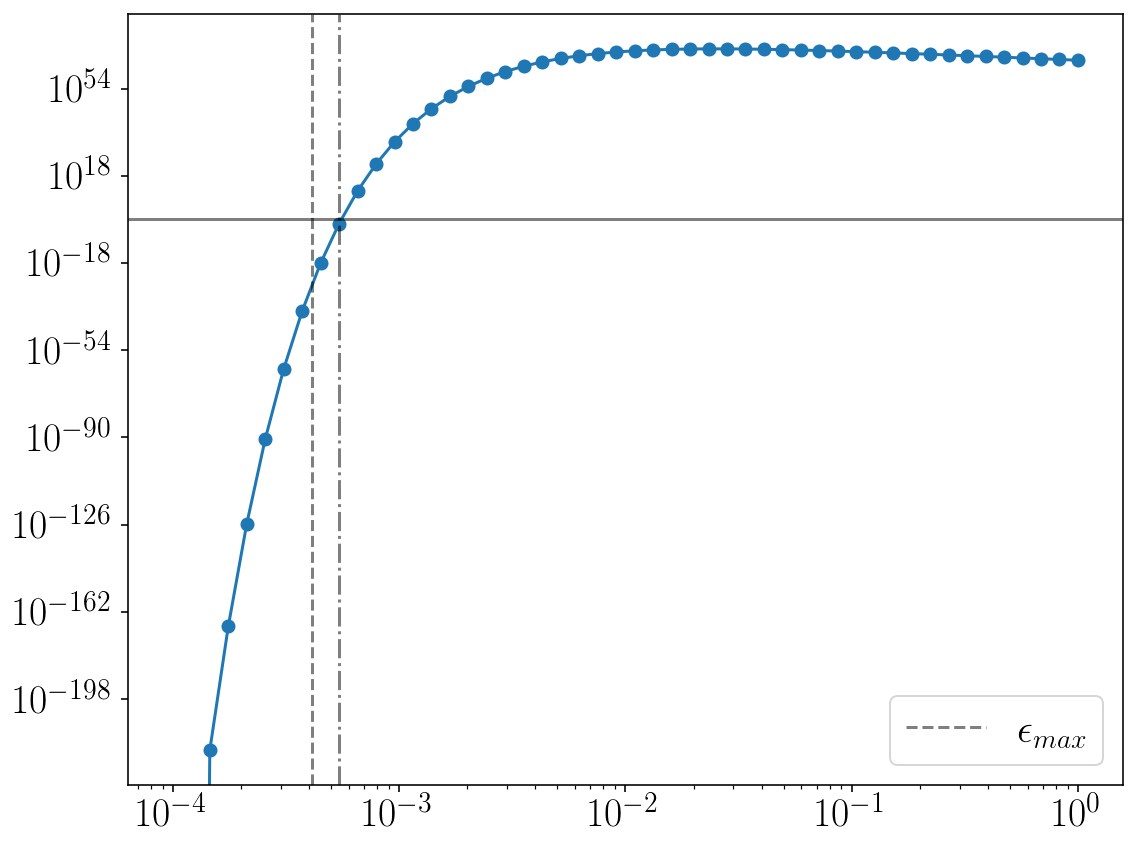

In [24]:
plt.plot(eps_range,Nucfun(eps_range))
plt.scatter(eps_range,nucleation_range)

plt.axhline(y=1,linestyle="-",color="k",alpha=.5)
plt.axvline(x=epsilon,linestyle="dashdot",color="k",alpha=.5)
plt.axvline(x=epsilon_max,linestyle="dashed",color="k",alpha=.5,label="$\epsilon_{max}$")

plt.legend(loc="best",prop={'size': label_size})

plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.tight_layout()

In [34]:
Ngb_val=4
n_val=15
f_val=1000
Mscale_val=4*np.pi*f_val
epsilon_val=1e-2*epsilon_bound(f_val,Mscale_val,n_val,Ngb_val)

epsilon_range=np.logspace(-9,-1)
S4_list=[]
for eps in epsilon_range:
    S4,S4_approx=find_S4(Ngb_val, n_val, Mscale_val, f_val, eps)
    S4_list.append(S4)

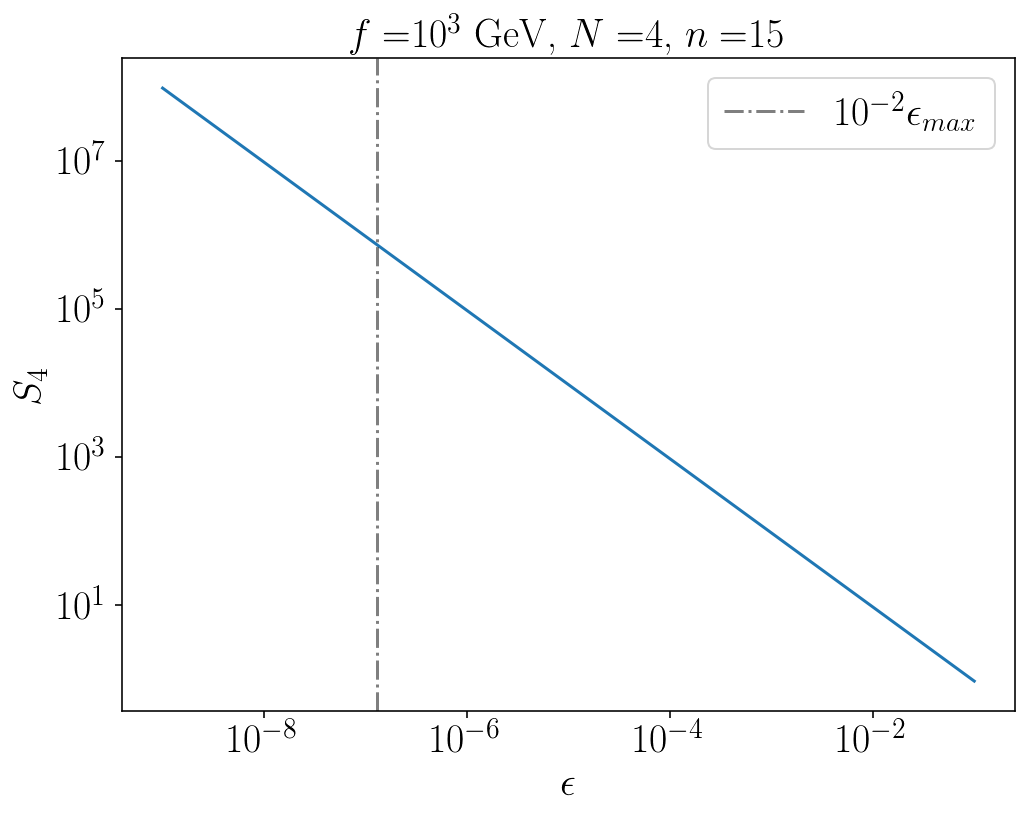

In [47]:
plt.plot(epsilon_range,S4_list)
plt.axvline(x=epsilon_val,linestyle="dashdot",color="k",alpha=.5,label="$10^{-2}\epsilon_{max}$")
plt.yscale("log")
plt.xscale("log")
plt.legend(prop={'size': label_size})
plt.xlabel("$\epsilon$",size=label_size)
plt.ylabel("$S_4$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+ ", $N=$"+str(Ngb_val)+
          ", $n=$"+str(n_val),size=label_size)
#plt.tight_layout()
plt.savefig('./PLOTS/S4_numerical.pdf', dpi=300)
plt.show()

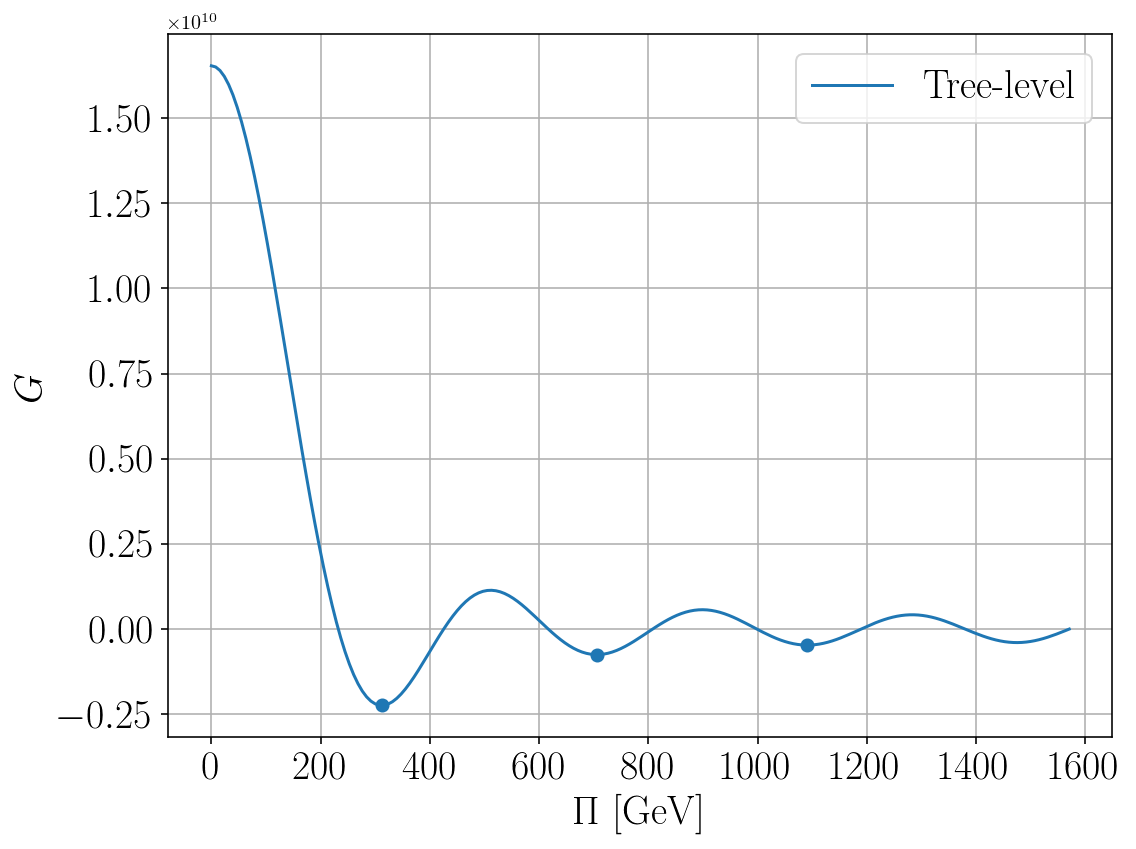

In [23]:
Ngb_val=4
n_val=15
f_val=1000
Mscale_val=4*np.pi*f_val
epsilon_val=1e-2*epsilon_bound(f_val,Mscale_val,n_val,Ngb_val)
epsilon_val=7.7*1e-7

m=model1(Ngb=Ngb_val, n=n_val,Mscale=Mscale_val,f=f_val,epsilon=epsilon_val)

m.plot1()

In [24]:
m.vacua_list*m.f

array([ 311.97301791,  705.91417257, 1091.21077897])

In [25]:
#phi_absMin,phi_metaMin = (m.vacua_list*m.f)[0:2]
phi_absMin,phi_metaMin = (m.vacua_list*m.f)[0], (m.vacua_list*m.f)[-1]
instanton=SingleFieldInstanton(phi_absMin, phi_metaMin,m.V0,alpha=3 )
profile=instanton.findProfile()
S4=instanton.findAction(profile)

S4


34827.7789403443

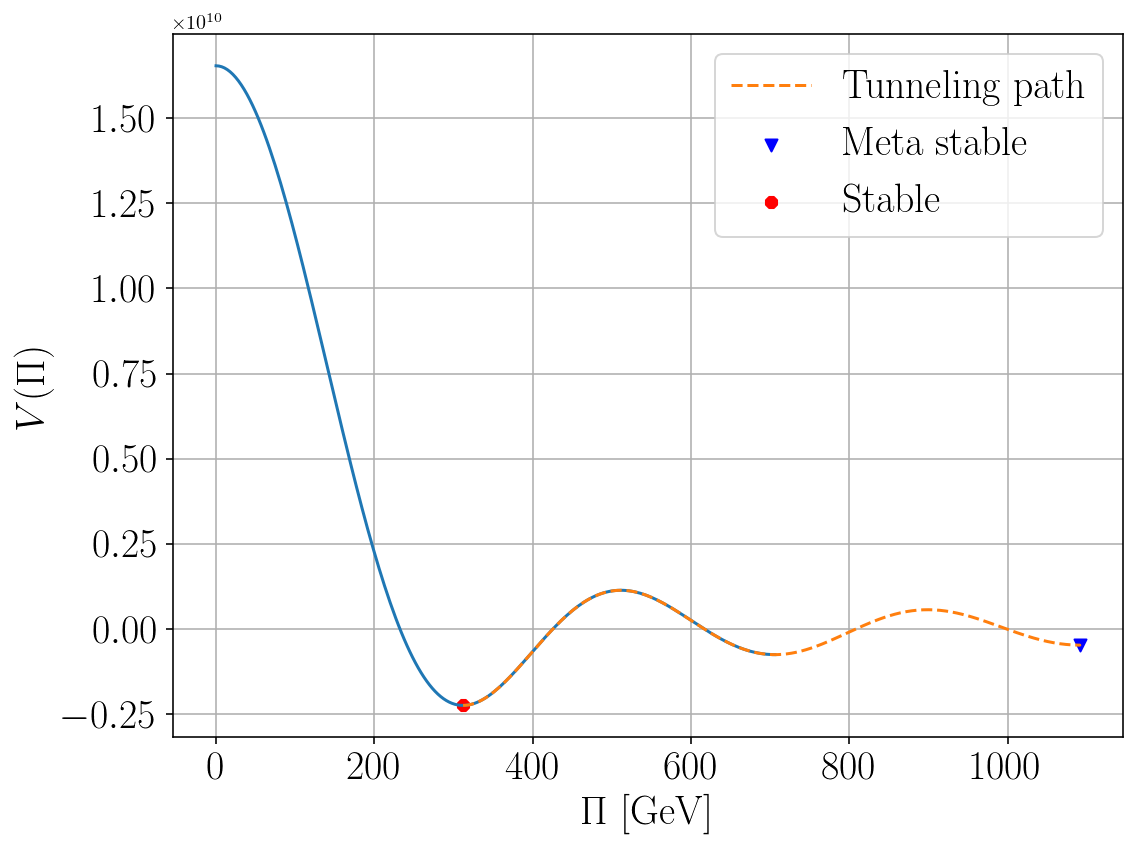

In [26]:
z_range=np.linspace(0,(m.vacua_list*m.f)[1],200)

plt.plot(z_range,m.V0(z_range))

plt.scatter(phi_metaMin,m.V0(phi_metaMin),label="Meta stable",color="b",marker="v")
plt.scatter(phi_absMin,m.V0(phi_absMin),label="Stable",color="r",marker="8")

plt.plot(profile.Phi,m.V0(profile.Phi),label="Tunneling path",ls="--")


plt.xlabel("$\Pi$ [GeV]",size=label_size)
plt.ylabel("$V(\Pi)$",size=label_size)
plt.legend()
plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
#mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
#plt.title(mytitle,size=label_size)
plt.tight_layout()
#plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
#plt.show()

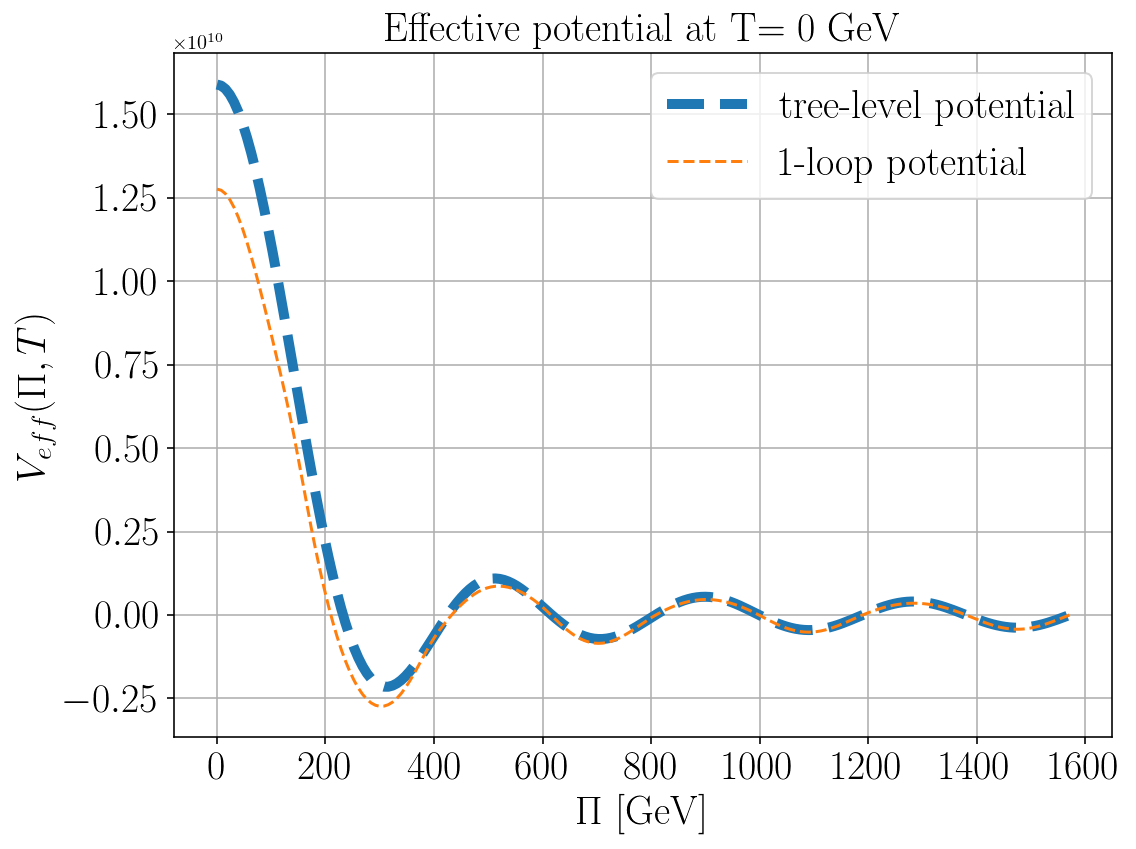

In [22]:
#def plot2(self,T):
T=0*m.f
z_range=np.linspace(1e-6,m.f*np.pi/2,200)
plt.plot(z_range,m.V0(z_range),"--",linewidth=5,label="tree-level potential")
plt.plot(z_range,m.Vtot(z_range,T),"--",label="1-loop potential")
#plt.xlim(0,phi_metaMin)    
plt.legend()
plt.legend(prop={'size': label_size})
plt.xlabel("$\Pi$ [GeV]",size=label_size)
plt.ylabel("$V_{eff}(\Pi,T)$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
mytitle="Effective potential at T= "+str(np.round(T,1))+" GeV"
plt.title(mytitle,size=label_size)
plt.tight_layout()
#plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
#plt.show()